In [1]:
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# from langchain_openai import OpenAIEmbeddings
import shap
from nltk.corpus import stopwords
import string

In [2]:
pcp_pattern = re.compile(r'\(PCP Entry\)(.*?)(?=\(\w+ Entry\)|$)', re.DOTALL)
specialist_pattern = re.compile(r'\(Specialist Entry\)(.*?)(?=\(\w+ Entry\)|$)', re.DOTALL)

def clean_text(text):
    text = text.strip()
    # Remove any log-like patterns within the text
    text = re.sub(r'\d{2}-\w{3}-\d{4} \d{2}:\d{2}', '', text)
    text = re.sub(r'\(.*?\):', '', text)
    text = re.sub(r'(PCP asked question|PCP Closed Request|Specialist requested referral|PCP will make referral):', '', text)
    text = re.sub(r'\n+', '\n', text).strip()
    
    remove_words = ['log', 'summary', 'entry']
    
    # List of months to be removed
    months = [
        'jan', 'feb', 'mar', 'apr', 'may', 'jun',
        'jul', 'aug', 'sep', 'oct', 'nov', 'dec'
    ]
    
    # high freq words
    lst_frequentwords=['pcp', 'summary', 'log', 'entry', 'specialist', 'econsult','recommendation','reason','question','asked', 
    'frailty','frail', '20min','would', 'patient', 'mg','provided','request','econsult created','log summary','pcp entry', 
    'pcp asked question','assigner entry','econsult assigned','specialist entry','specialist provided recommendation of', 
    'pcp closed request','pcp accepted recommendation','specialist requested referral','pcp will make referral','created', 
    'assigned','assigner','closed','time','daily','year','requested referral','dementia','demented','démence','Alz','memory','cognitive impairment' 
    ] 
    for word in lst_frequentwords:
        text = text.replace(word, '')
    
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation+string.digits))
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    stop_words.update(remove_words)
    stop_words.update(months)
    
    cleaned_text = ' '.join([word for word in text.split() if word not in stop_words])
    
    return cleaned_text

# Model 1

In [3]:
df_dementia = pd.read_excel("FinalDementia2021Taxonomy_4DEC2023.xlsx", sheet_name="Data")
df_dementia.head(1)

,ID,CODE CATEGORY,PRELIMINARY DIAGNOSIS (TD),REMOVE FROM ANALYSIS,"Based on log details, this case involves a patient with dementia","Based on log details, this patient is a current LTC resident","PCP question and/or specialist response mentions needs, resources, services, or assistance for caregiver(s)?",Is the PCP question directly related to the patient's dementia?,Did the specialist consider the patient's dementia in their response?,Content Classification - Blood,...,Diff Created-Resonse,Time Spent,Cost,Iteration,Q1,Q2,Q3,Q4,Log Details,Form State
0,1,LTC,Dementia,NO,True,True,False,No,No,False,...,0.279236,5,16.666667,1,2,1,4,5,17-Aug-2021 07:16 (Log Summary): (PCP Entry) P...,Completed (PCP accepted recommendation)


In [1]:
df_non_dementia = pd.read_excel("Urban_NonLTC_Controlx2_15DEC2023.xlsx", sheet_name="100 Urban Non LTC Control")
df_non_dementia.head(1)

In [5]:
df_dementia['Log Details'] = df_dementia['Log Details'].apply(clean_text)
df_non_dementia['Log Detail'] = df_non_dementia['Log Detail'].apply(clean_text)

In [6]:
dementia_data = df_dementia['Log Details'].values
non_dementia_data = df_non_dementia['Log Detail'].values

In [7]:
dementia_labels = np.ones(len(dementia_data))
non_dementia_labels = np.zeros(len(non_dementia_data))

In [8]:
X_log_1 = np.concatenate((dementia_data, non_dementia_data))
y_1 = np.concatenate((dementia_labels, non_dementia_labels))

In [9]:
# import wordcloud
# wc = wordcloud.WordCloud(background_color='black', max_words=50, max_font_size=45)
# wc = wc.generate(str(X_log_1[0]))
# fig = plt.figure(num=1)
# plt.axis('off')
# plt.imshow(wc, cmap=None)
# plt.show()

In [9]:
vectorizer_1 = TfidfVectorizer()
X_1 = vectorizer_1.fit_transform(X_log_1)

In [10]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.2)

In [11]:
model_1 = LogisticRegression()
model_1.fit(X_train_1, y_train_1)

LogisticRegression()

In [12]:
y_pred_1 = model_1.predict(X_1)

In [13]:
accuracy = accuracy_score(y_1, y_pred_1)
report = classification_report(y_1, y_pred_1)

In [14]:
print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

Accuracy: 0.9774436090225563
Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       200
         1.0       0.98      0.97      0.98       199

    accuracy                           0.98       399
   macro avg       0.98      0.98      0.98       399
weighted avg       0.98      0.98      0.98       399



In [16]:
# Compute the confusion matrix
cm = confusion_matrix(y_1, y_pred_1)

# Extract True Negatives (TN), False Positives (FP), False Negatives (FN), True Positives (TP)
TN, FP, FN, TP = cm.ravel()

# Display the confusion matrix
print("Confusion Matrix:")
print(cm)

# Explain each term
print("\nItems in the Confusion Matrix:")
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print(f"True Positives (TP): {TP}")

# Identify False Positives and False Negatives
false_positives = [i for i, (true, pred) in enumerate(zip(y_1, y_pred_1)) if true == 0 and pred == 1]
false_negatives = [i for i, (true, pred) in enumerate(zip(y_1, y_pred_1)) if true == 1 and pred == 0]

print("\nIndices of False Positives:", false_positives)
print("Indices of False Negatives:", false_negatives)


Confusion Matrix:
[[196   4]
 [  5 194]]

Items in the Confusion Matrix:
True Negatives (TN): 196
False Positives (FP): 4
False Negatives (FN): 5
True Positives (TP): 194

Indices of False Positives: [204, 298, 304, 398]
Indices of False Negatives: [67, 80, 112, 129, 179]


In [17]:
false_positives + false_negatives

[204, 298, 304, 398, 67, 80, 112, 129, 179]

In [15]:
y_pred_prob_1 = model_1.predict_proba(X_1)

C:\Users\pouri\anaconda3\lib\site-packages\shap\explainers\_linear.py:95: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


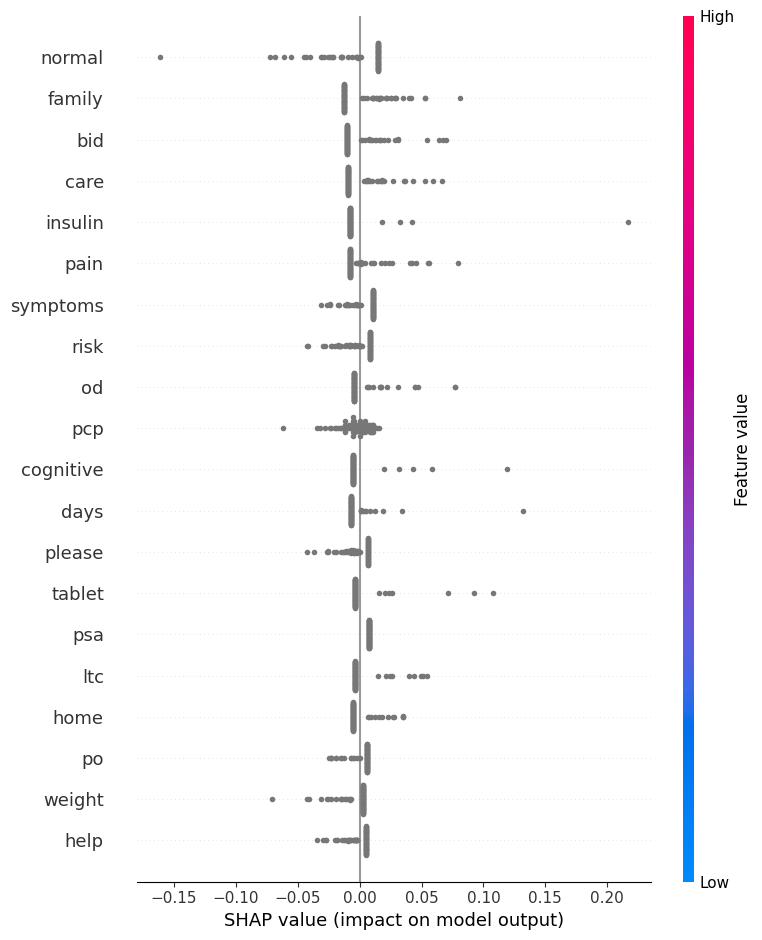

In [17]:
explainer = shap.LinearExplainer(model_1, X_train_1, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_test_1)
shap.initjs()
shap.summary_plot(shap_values, X_test_1, feature_names=vectorizer_1.get_feature_names_out())

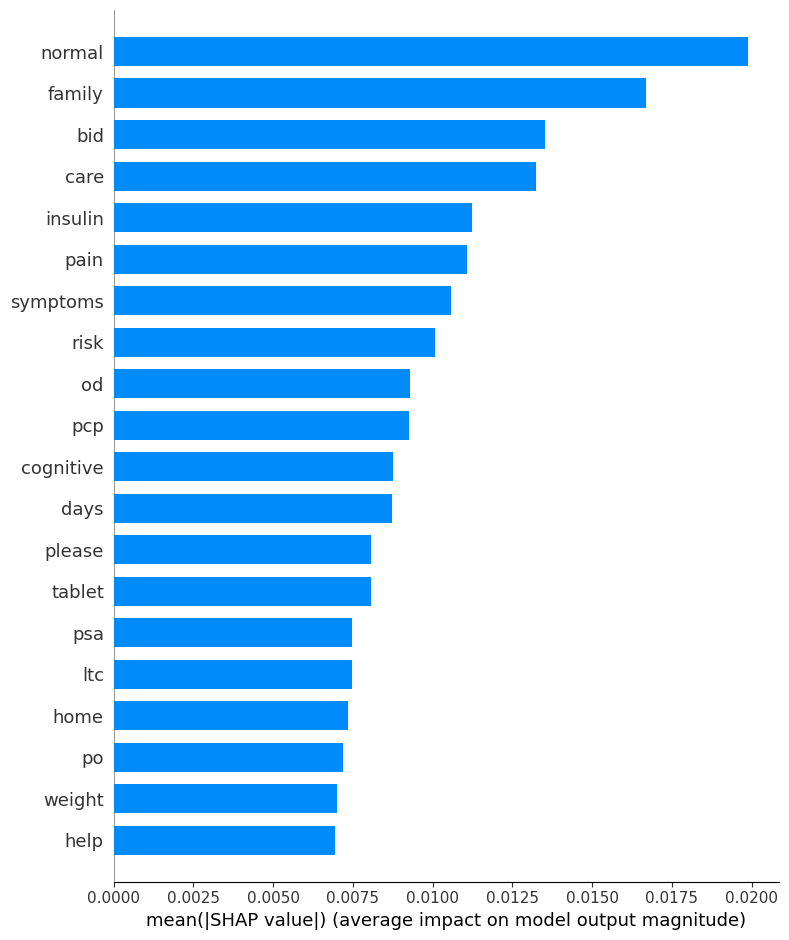

In [18]:
shap.summary_plot(shap_values, X_test_1, feature_names=vectorizer_1.get_feature_names_out(), plot_type="bar")

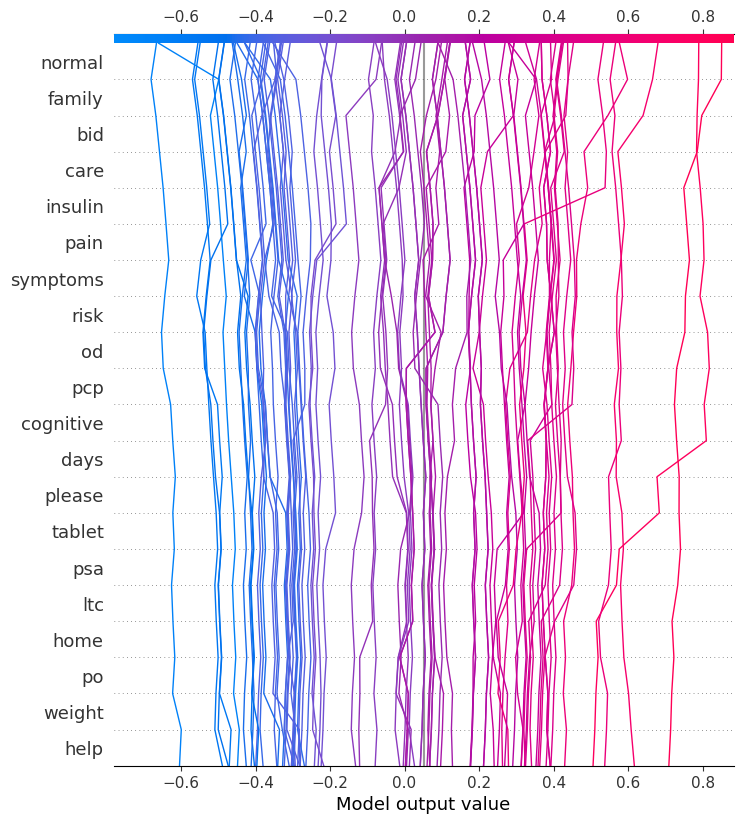

In [19]:
shap.decision_plot(explainer.expected_value, shap_values, X_test_1.toarray(), feature_names=vectorizer_1.get_feature_names_out())

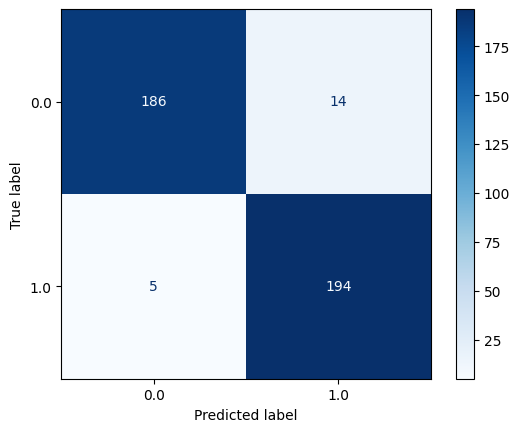

In [20]:
cm = confusion_matrix(y_1, y_pred_1)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(y_1)))
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

model_1 = SVC()
model_1.fit(X_train_1.toarray(), y_train_1)

SVC()

In [22]:
from sklearn.model_selection import cross_val_score

In [23]:
scores = cross_val_score(model_1, X_1.toarray(), y_1, cv=10)

In [24]:
scores

array([1.        , 1.        , 1.        , 0.975     , 1.        ,
       1.        , 0.975     , 0.975     , 1.        , 0.97435897])

In [25]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.99 accuracy with a standard deviation of 0.01


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Define models to evaluate
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True),
    "Decision Tree": DecisionTreeClassifier(),
    "Naive Bayes": GaussianNB()
}

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [27]:
# Metrics to evaluate
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='macro'),
    'recall': make_scorer(recall_score, average='macro'),
    'f1': make_scorer(f1_score, average='macro')
}

# Splitting data once for ROC analysis (outside of CV loop for efficiency)
X_train, X_test, y_train, y_test = train_test_split(X_1.toarray(), y_1, test_size=0.2, random_state=42, stratify=y_1)

# Collecting results
results = {}
roc_auc_results = {}

for model_name, model in models.items():
    scores = cross_validate(model, X_1.toarray(), y_1, scoring=scoring, cv=cv, n_jobs=-1)
    results[model_name] = {
        'accuracy': np.mean(scores['test_accuracy']),
        'precision': np.mean(scores['test_precision']),
        'recall': np.mean(scores['test_recall']),
        'f1': np.mean(scores['test_f1'])
    }
    
    # Train the model and calculate ROC and AUC
    model.fit(X_train, y_train)
    if hasattr(model, "predict_proba"):  # Check if model can predict probabilities
        y_prob = model.predict_proba(X_test)
    else:
        y_prob = model.decision_function(X_test)  # For models like SVM

    fpr = {}
    tpr = {}
    roc_auc = {}

    # If binary classification, calculate for single class
    if len(np.unique(y_test)) == 2:
        fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1])
        roc_auc = auc(fpr, tpr)
        roc_auc_results[model_name] = roc_auc
    else:  # Multiclass ROC
        for i in range(len(np.unique(y_test))):
            fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        roc_auc_results[model_name] = np.mean(list(roc_auc.values()))  # Mean AUC for multiclass

# Convert results to a DataFrame
results_df = pd.DataFrame(results).T

# Add AUC scores to the DataFrame
results_df['auc'] = [roc_auc_results[model] for model in results_df.index]


In [28]:
results_df

,accuracy,precision,recall,f1,auc
Logistic Regression,0.874778,0.878878,0.874679,0.874325,0.928125
Random Forest,0.894652,0.902055,0.894423,0.894027,0.946250
SVM,0.927342,0.933491,0.927436,0.927078,0.936250
Decision Tree,0.872089,0.889355,0.871667,0.870344,0.775000
Naive Bayes,0.919905,0.922824,0.919936,0.919755,0.925000


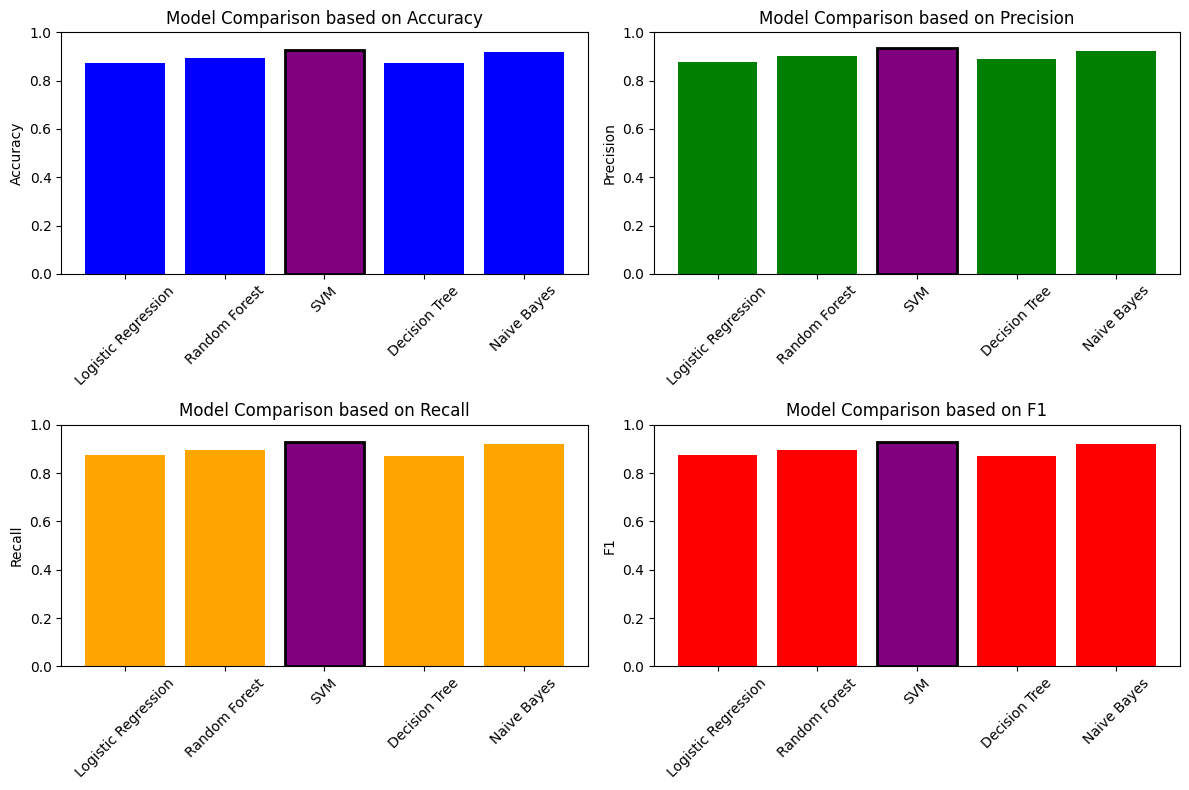

In [29]:
# Determine the champion model for each metric
champion_accuracy = results_df['accuracy'].idxmax()
champion_precision = results_df['precision'].idxmax()
champion_recall = results_df['recall'].idxmax()
champion_f1 = results_df['f1'].idxmax()

# Plotting the results
plt.figure(figsize=(12, 8))
metrics = ['accuracy', 'precision', 'recall', 'f1']
colors = ['blue', 'green', 'orange', 'red']

for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i + 1)
    bars = plt.bar(results_df.index, results_df[metric], color=colors[i])
    plt.title(f'Model Comparison based on {metric.capitalize()}')
    plt.ylabel(metric.capitalize())
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    
    # Highlight the champion model
    if metric == 'accuracy':
        champion_model = champion_accuracy
    elif metric == 'precision':
        champion_model = champion_precision
    elif metric == 'recall':
        champion_model = champion_recall
    elif metric == 'f1':
        champion_model = champion_f1
    
    for bar in bars:
        if bar.get_x() + bar.get_width() / 2 == results_df.index.get_loc(champion_model):
            bar.set_color('purple')
            bar.set_edgecolor('black')
            bar.set_linewidth(2)

plt.tight_layout()
plt.show()


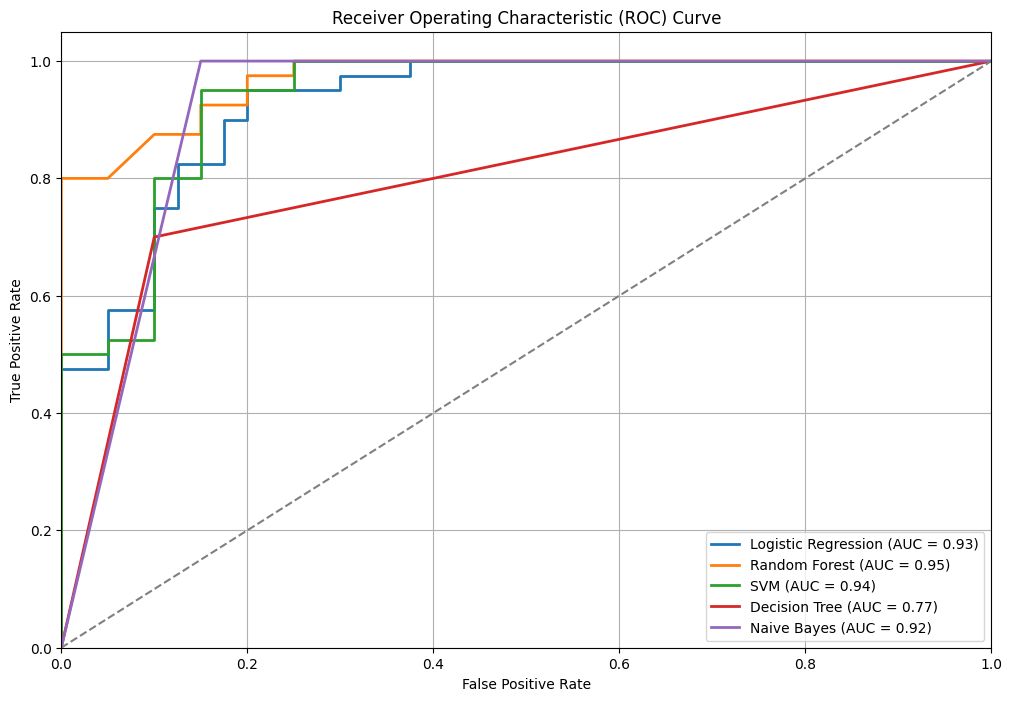

In [30]:
# Plotting ROC curves for the models
plt.figure(figsize=(12, 8))
for model_name in models.keys():
    model = models[model_name]
    model.fit(X_train, y_train)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)
    else:
        y_prob = model.decision_function(X_test)

    if len(np.unique(y_test)) == 2:
        fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1])
        plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc_results[model_name]:.2f})')
    else:
        for i in range(len(np.unique(y_test))):
            fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
            plt.plot(fpr[i], tpr[i], lw=2, label=f'{model_name} - Class {i} (AUC = {roc_auc_results[model_name]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Model 2

In [20]:
df_dementia = pd.read_excel("FinalDementia_11APR2023_v2.xlsx", sheet_name="Final")
df_dementia.head(1)

,Form ID,Lookup Terms,Dementia Diagnosis,Dementia Diagnosis Refined,Log Details,Pt Age,Pt Gender,Specialty,Iterations,Urban/Rural Flag,LTC PCP Flag,LTC Text Flag,LTC Identification Final,LTC Identification Refined
0,014a2369-a49a-41d1-8f26-78ecd69d0c42,Dementia/Alz,1,1,31-Mar-2021 13:17 (Log Summary): (PCP Entry) P...,73.849463,Female,Neurology,1,Rural,0,1,NO,2


In [21]:
df_dementia['Log Details'] = df_dementia['Log Details'].apply(clean_text)

In [22]:
X_log_2 = df_dementia['Log Details'].values
y_2 = [1 if i==1 else 0 for i in df_dementia['Dementia Diagnosis Refined'].values]

In [23]:
vectorizer_2 = TfidfVectorizer()
X_2 = vectorizer_2.fit_transform(X_log_2)

In [24]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=42)

In [25]:
model_2 = DecisionTreeClassifier(max_depth=10)
model_2.fit(X_train_2, y_train_2)

DecisionTreeClassifier(max_depth=10)

In [26]:
y_pred_2 = model_2.predict(X_2)

In [27]:
accuracy = accuracy_score(y_2, y_pred_2)
report = classification_report(y_2, y_pred_2)

In [28]:
print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

Accuracy: 0.9468302658486708
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       187
           1       0.96      0.95      0.96       302

    accuracy                           0.95       489
   macro avg       0.94      0.95      0.94       489
weighted avg       0.95      0.95      0.95       489



In [29]:
y_pred_prob_2 = model_2.predict_proba(X_2)

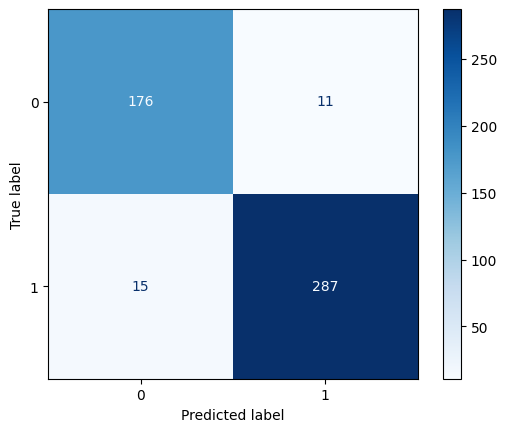

In [30]:
cm = confusion_matrix(y_2, y_pred_2)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(y_2)))
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Mixture

In [31]:
X_1_2 = vectorizer_2.transform(X_log_1)
y_pred_1_2 = model_2.predict(X_1_2)

In [32]:
accuracy = accuracy_score(y_1, y_pred_1_2)
report = classification_report(y_1, y_pred_1_2)
print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

Accuracy: 0.8646616541353384
Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.77      0.85       200
         1.0       0.81      0.96      0.88       199

    accuracy                           0.86       399
   macro avg       0.88      0.86      0.86       399
weighted avg       0.88      0.86      0.86       399



# Correlation

In [31]:
sim_score = pd.read_csv('max_sim_df.csv', usecols=['severe'])

In [32]:
clf_prob_dementia = pd.DataFrame(y_pred_prob_1[:, 1], columns=['severe'])
clf_prob_non_dementia = pd.DataFrame(y_pred_prob_1[:, 0], columns=['severe'])

In [33]:
correlation_matrix = sim_score.corrwith(clf_prob_dementia, method='pearson')
print(correlation_matrix)

severe    0.523707
dtype: float64


In [43]:
correlation_matrix = sim_score.corrwith(clf_prob_non_dementia, method='pearson')
print(correlation_matrix)

severe   -0.523707
dtype: float64


In [42]:
from scipy.stats import pearsonr

correlation, p_value = pearsonr(y_pred_prob_1[:, 1], np.array(sim_score['severe']))
correlation, p_value

(0.5237072309461296, 1.7550468498280242e-29)

In [59]:
#

In [60]:
sim_score = pd.read_csv('max_sim_df_none.csv', usecols=['none'])

In [61]:
clf_prob_dementia = pd.DataFrame(y_pred_prob_1[:, 1], columns=['none'])
clf_prob_non_dementia = pd.DataFrame(y_pred_prob_1[:, 0], columns=['none'])

In [62]:
correlation_matrix = sim_score.corrwith(clf_prob_dementia, method='pearson')
print(correlation_matrix)

none    0.442404
dtype: float64


In [63]:
correlation_matrix = sim_score.corrwith(clf_prob_non_dementia, method='pearson')
print(correlation_matrix)

none   -0.442404
dtype: float64


# Topics mapping

In [155]:
import pickle as pkl

with open("topics.pkl", "rb") as f:
    topics = pkl.load(f)
    
topics = np.array(topics)

In [156]:
import numpy as np
from collections import Counter


def map_clusters_to_labels(labels, clusters):
    cluster_to_labels = {}
    
    for cluster in np.unique(clusters):
        # Get the indices of the data points in the current cluster
        cluster_indices = np.where(clusters == cluster)[0]
        
        # Get the labels of the data points in the current cluster
        cluster_labels = labels[cluster_indices]
        
        # Count the occurrences of each label in the current cluster
        label_counts = Counter(cluster_labels)
        
        # Find the label with the maximum count
        majority_label = label_counts.most_common(1)[0][0]
        
        # Map the cluster to the majority label
        cluster_to_labels[cluster] = majority_label
    
    return cluster_to_labels

# Mapping clusters to labels
cluster_label_mapping = map_clusters_to_labels(y_pred_1, topics)
print(cluster_label_mapping)


{-1: 1.0, 0: 0.0, 1: 0.0, 2: 1.0, 3: 1.0, 4: 0.0}


In [157]:
y = [cluster_label_mapping[val] for val in topics]

In [158]:
outliers = np.where(topics==-1)[0]
outliers

array([  0,   1,   9,  32,  34,  44,  77,  96, 110, 120, 123, 133, 159,
       188, 192, 219, 220, 222, 319, 320, 322], dtype=int64)

In [159]:
inconsistent_indices = np.where(y != y_1)[0]
len(inconsistent_indices)

175

In [160]:
misclassified_indices = np.where(y_1 != y_pred_1)[0]
misclassified_indices

array([ 26,  92, 115, 133, 143, 177, 193, 229, 274, 281, 329, 374, 381],
      dtype=int64)

In [161]:
misclassified_inconsistent = set(inconsistent_indices).intersection(set(misclassified_indices))
misclassified_inconsistent = list(misclassified_inconsistent)
misclassified_inconsistent

[193, 143, 177, 274, 115, 374, 281, 26, 381]

In [162]:
len(misclassified_inconsistent)

9

In [163]:
X_log_1 = np.delete(X_log_1, misclassified_inconsistent)
y_1 = np.delete(y_1, misclassified_inconsistent)

# Recommender mapping

In [293]:
from surprise import Dataset, NormalPredictor, Reader, SVD
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split

In [310]:
len(X_log_1)

399

In [322]:
ratings_dict = {
    "itemID": np.array(X_log_1),
    "userID": topics,
    "rating": y_1,
}
df_recommender = pd.DataFrame(ratings_dict)
df_recommender

,itemID,userID,rating
0,pcp yr old female living long term care nursin...,-1,1.0
1,pcp thank guidance diabetic management yo fema...,-1,1.0
2,pcp thank recommendations regarding management...,2,1.0
3,pcp yr female resident ltc noted expanding tum...,3,1.0
4,pcp yo male resident long term care advanced d...,3,1.0
...,...,...,...
394,pcp problem yearold female complicated pmh inc...,4,0.0
395,pcp dear urologist would appreciate guidance p...,4,0.0
396,pcp david moore age yr thank reviewing psa num...,4,0.0
397,pcp econsult reason consultation •medically co...,4,0.0


In [323]:
reader = Reader(rating_scale=(0, 2))
data = Dataset.load_from_df(df_recommender[["userID", "itemID", "rating"]], reader)

In [324]:
algo = SVD()
cross_validate(algo, data, cv=5, verbose=True);

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.4471  0.4559  0.4668  0.4371  0.4507  0.4515  0.0098  
MAE (testset)     0.4337  0.4413  0.4503  0.4279  0.4397  0.4386  0.0075  
Fit time          0.01    0.01    0.01    0.00    0.00    0.01    0.00    
Test time         0.00    0.00    0.00    0.00    0.01    0.00    0.00    


In [325]:
algo.fit(data.build_full_trainset())

In [326]:
a = np.array(data.raw_ratings)
a[:, 2]

array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,
       1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,
       1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,
       1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,
       1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,
       1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,
       1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,
       1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,
       1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,
       1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,
       1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,
       1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,
       1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,
       1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.

In [327]:
uid = str(np.array(data.raw_ratings)[:, 0][10])
iid = str(np.array(data.raw_ratings)[:, 1][10])

pred = algo.predict(uid, iid, r_ui=None)
print(pred.est)

0.5484341856661676


In [328]:
y_pred = []
for i in range(len(df_recommender)):
    uid = str(np.array(data.raw_ratings)[:, 0][i])
    iid = str(np.array(data.raw_ratings)[:, 1][i])
    y = algo.predict(uid, iid, r_ui=np.array(data.raw_ratings)[:, 2][i])
    y_pred.append(y.est)

In [329]:
def normalize(value, min_value, max_value):
    return (value - min_value) / (max_value - min_value)

def map_to_discrete(normalized_value):
    if normalized_value < 1/2:
        return 0
    else:
        return 1

In [330]:
min_val, max_val = min(y_pred), max(y_pred)

In [331]:
y_pred0 = []
for i in range(len(df_recommender)):
    uid = str(np.array(data.raw_ratings)[:, 0][i])
    iid = str(np.array(data.raw_ratings)[:, 1][i])
    y = algo.predict(uid, iid, r_ui=np.array(data.raw_ratings)[:, 2][i])
    
    normalized_value = normalize(y.est, min_val, max_val)
    discrete_value = map_to_discrete(normalized_value)
    
    y_pred0.append(discrete_value)

In [332]:
accuracy_score(y_pred0, y_1)

1.0

In [333]:
differences_index = []
for i, l in enumerate(y_1):
    if l != y_pred0[i]:
        differences_index.append(i)
len(differences_index)

0

In [334]:
y_1

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [335]:
topics

array([-1, -1,  2,  3,  3,  3,  1,  2,  3, -1,  1,  4,  4,  4,  3,  3,  3,
        2,  3,  2,  3,  4,  3,  3,  1,  3,  4,  4,  4,  3,  1,  2, -1,  3,
       -1,  3,  4,  3,  4,  1,  4,  3,  3,  3, -1,  3,  3,  3,  1,  4,  4,
        2,  4,  0,  1,  4,  4,  1,  0,  4,  3,  3,  3,  0,  0,  3,  3,  4,
        3,  3,  3,  1,  0,  0,  1,  4,  1, -1,  2,  2,  4,  3,  1,  1,  1,
        4,  0,  3,  0,  1,  1,  4,  2,  1,  2,  1, -1,  0,  0,  2,  0,  0,
        0,  3,  0,  0,  1,  4,  1,  1, -1,  0,  1,  2,  0,  0,  0,  1,  1,
        4, -1,  0,  4, -1,  3,  0,  3,  1,  1,  1,  2,  2,  1, -1,  0,  1,
        4,  4,  1,  3,  0,  1,  4,  0,  4,  1,  1,  0,  1,  0,  4,  0,  1,
        0,  2,  0,  4,  0,  2, -1,  1,  1,  3,  1,  0,  0,  3,  4,  1,  2,
        3,  4,  0,  4,  0,  1,  1,  0,  4,  4,  2,  2,  1,  0,  0,  3,  4,
        4, -1,  0,  4,  1, -1,  0,  0,  0,  0,  0,  0,  1,  0,  4,  0,  0,
        0,  4,  4,  3,  3,  3,  3,  3,  3,  3,  3,  0,  0,  0,  4, -1, -1,
        2, -1,  4,  4,  4

In [338]:
X_log_1[-1]

'pcp hello years old paraplegic patient mine regular wound care pressure sores paramed wound care wrote since couldnt find amd packing material last dressing change wanted know way see still wound mention dressing open bottom fallen seen xray think imaging necessary thank pcp econsult created assigner econsult assigned specialist specialist provided recommendation thank consult would normally visible xray deep wound would suggest irrigating wound gage needle cc syringe use lease cc normal saline water pressure dislodge packing might left wound nurses measuring wound weekly good practice know depth wound wound depth likely packing wound greater expected decrease depth wound probed would use imaging last resort note wounds loosely packed packing one piece large enough tail packing left decrease risk packing left wound please feel free contact questions thank including patients care kimberly leblanc phd rn nswoc woccc fcan pcp pcp accepted recommendation'